## Метод К средних

Начнем наш анализ с того, что обнаружим города и прилегающие к ним области, в которых происходит наибольшее количество аварий. Это довольно полезно: например, если обнаружится область с необычно большим скоплением аварий, можно сделать выводы о плохом устройстве местной дорожной сети и направить силы на устранение этого.

Но предоставленных данных нет соответствия между городами и объектами. Давайте его построим, используя метод К средних!

Для этого будем использовать данные о широте и долготе аварий. 

Загрузим данные об авариях:


In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score


practice_data = pandas.read_csv('../../data/homework_2_data.csv').filter(
    items=['Speed_limit', 'Longitude', 'Latitude'])
practice_data.head()

,Speed_limit,Longitude,Latitude
0,30,-0.191170,51.489096
1,30,-0.211708,51.520075
2,30,-0.206458,51.525301
3,30,-0.173862,51.482442
4,30,-0.156618,51.495752


В приведенной выше таблице нас интересуют две колонки: Longitude, Latitude. Давайте визуализируем их.

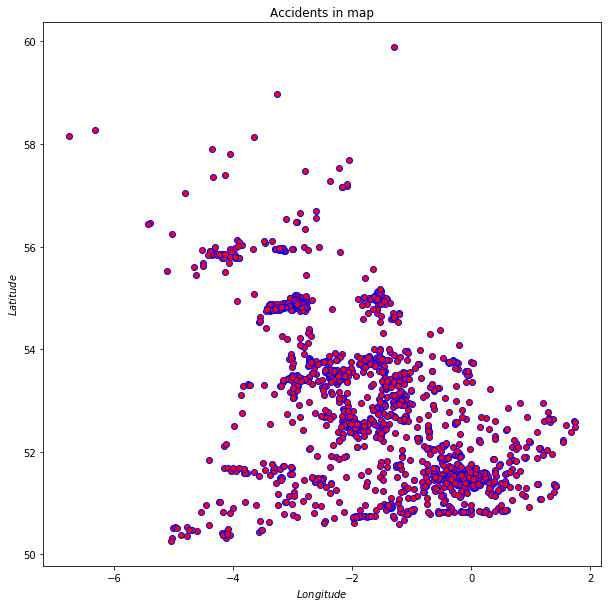

In [3]:
def draw_long_lat_plot():
    fig, (ax1) = plt.subplots(
        nrows=1, ncols=1,
        figsize=(10, 10)
    )

    ax1.scatter(x=practice_data["Longitude"], y=practice_data["Latitude"], c='r', edgecolor='b', alpha=1)
    ax1.set_title('Accidents in map')
    ax1.set_xlabel('$Longitude$')
    ax1.set_ylabel('$Latitude$')
draw_long_lat_plot()

Уже отчетливо видны большие города, например Лондон (внизу справа). Давайте попробуем применить метод K средних для 5и и для 9и кластеров.

In [4]:
def draw_long_lat_city_plot(cities_5, cities_9):
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(20, 10)
    )

    ax1.scatter(x=practice_data["Longitude"], y=practice_data["Latitude"],
                c=cities_5, edgecolor='b', cmap='Paired', alpha=0.9, linewidths=0.5)
    ax1.set_title('Кластеризация с k = 5')
    ax1.set_xlabel('$Longitude$')
    ax1.set_ylabel('$Latitude$')
    
    ax2.scatter(x=practice_data["Longitude"], y=practice_data["Latitude"],
                c=cities_9, edgecolor='b', cmap='Paired', alpha=0.9, linewidths=0.5)
    ax2.set_title('Кластеризация с k = 9')
    ax2.set_xlabel('$Longitude$')
    ax2.set_ylabel('$Latitude$')

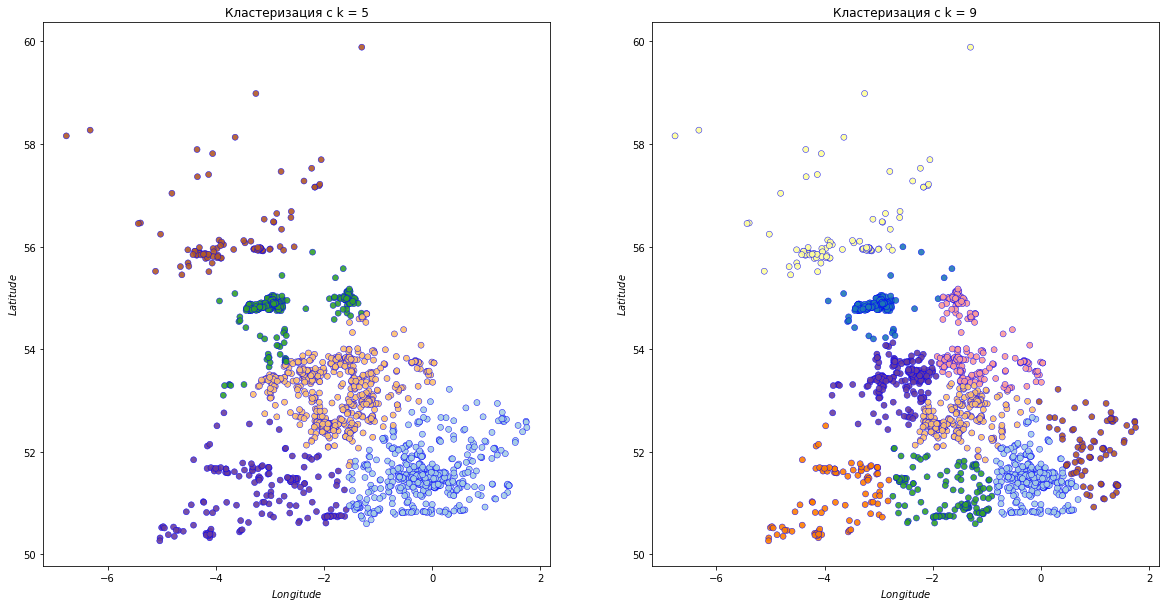

In [5]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

filtered_data = practice_data.filter(items=['Longitude', 'Latitude'])

model_5 = KMeans(n_clusters=5)
model_5.fit(filtered_data)

model_9 = KMeans(n_clusters=9)
model_9.fit(filtered_data)


draw_long_lat_city_plot(model_5.predict(filtered_data), model_9.predict(filtered_data))

Мы решили добавить еще один параметр для того, чтобы выделить внутри городов улицы: ограничение скорости. Построим график, на котором более красным цветом будут обозначаться аварии, произошедшие на дорогах с наиболее допустимой скоростью.

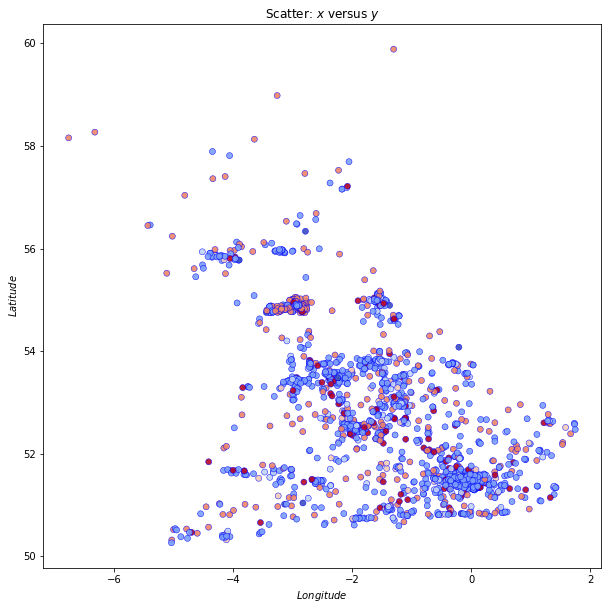

In [7]:
def draw_long_lat_speed_plot():
    fig, (ax1) = plt.subplots(
        nrows=1, ncols=1,
        figsize=(10, 10)
    )

    ax1.scatter(x=practice_data["Longitude"], y=practice_data["Latitude"],
                c=practice_data["Speed_limit"],edgecolor='b', cmap='coolwarm', alpha=0.9, linewidths=0.5)
    ax1.set_title('Scatter: $x$ versus $y$')
    ax1.set_xlabel('$Longitude$')
    ax1.set_ylabel('$Latitude$')
draw_long_lat_speed_plot()

Разделим эту картину на кластеры, используя уже знакомый нам метод K средних. Не забудем промасштабировать данные, поскольку макс. скорость и координаты имеют разный разброс значений

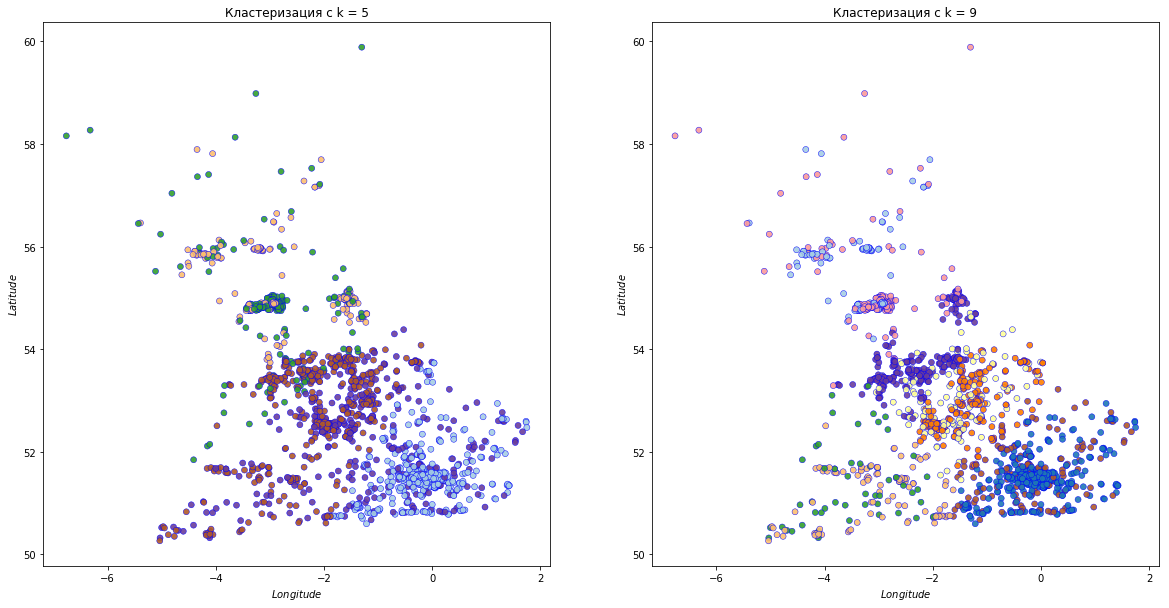

In [9]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(practice_data)
scaled_data = scaler.transform(practice_data)


model_5 = KMeans(n_clusters=5)
model_5.fit(scaled_data)

model_9 = KMeans(n_clusters=9)
model_9.fit(scaled_data)


draw_long_lat_city_plot(model_5.predict(scaled_data), model_9.predict(scaled_data))

Полученные результаты можно назвать удовлетворительными, поскольку сколько-нибудь полезная картина получилась только для Лондона: видно, что на центральных улицах скорость намного меньше.

Для полной картины было бы полезно иметь больше данных, чтобы была видна кластеризация на улице. Ну что ж, тоже результат.

## Таблица сопряженности

Еще одним фактом помогающим улучшить дорожную инфраструктуру является статистика о поле, возрасте и виде транспорта, попадаемых в аварии. Давайте построим таблицы сопряженности, помогающие получить эту информацию. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tabletext

warnings.filterwarnings('ignore')

Загрузим данные о возрасте, поле и виде транспорта.

In [23]:
df = pd.read_csv('../../data/Vehicles03.csv')
df.head()

,Vehicle_Type,Sex_of_Driver,Age_of_Driver
0,9,2,74.0
1,11,1,42.0
2,11,1,35.0
3,9,1,62.0
4,9,2,49.0


По нашему предположению, довольно большой процент аварий происходит с мотоциклистами. Добавим номинальный признак, который говорил бы, что т.с. - мотоцикл. Также, добавим номинальный признак, равный единице тогда, когда участники аварии моложе 40 лет.

In [24]:
# Motorcylce, vehilce type should be >=2 and <= 5
df = df.assign(Is_Motorcylce=df.Vehicle_Type.copy())
df["Is_Motorcylce"] = 1
df.loc[df["Vehicle_Type"]<2, "Is_Motorcylce"] = 0
df.loc[df["Vehicle_Type"]>5, "Is_Motorcylce"] = 0
df.loc[df["Vehicle_Type"]==-1, "Is_Motorcylce"] = 0

del df["Vehicle_Type"]

# Driver is younger than 40
df = df.assign(Age_of_Driver_LEQ40=df.Age_of_Driver.copy())
df.loc[df["Age_of_Driver"]<=40, "Age_of_Driver_LEQ40"] = 1
df.loc[df["Age_of_Driver"]>40, "Age_of_Driver_LEQ40"] = 0
df.head()

del df["Age_of_Driver"]
df.head()

,Sex_of_Driver,Is_Motorcylce,Age_of_Driver_LEQ40
0,2,0,0.0
1,1,0,0.0
2,1,0,1.0
3,1,0,0.0
4,2,0,0.0


In [25]:
df.columns

Index(['Sex_of_Driver', 'Is_Motorcylce', 'Age_of_Driver_LEQ40'], dtype='object')

В качестве 3-х итоговых номинальных признаков выберем: "Sex_of_Driver", "Is_Motorcylce", "Age_of_Driver_LEQ40"

In [38]:
# Для удобства построим таблицы cross classification

a = [["Sex_of_Driver/Is_Motorcylce", "True", "False"], ["Man"], ["Woman"], ["Unknown"]]

total = df.shape[0]
for i in range(1, 4):
    for j in range(2):
        x = ((df["Sex_of_Driver"] == i) & (df["Is_Motorcylce"] == j)).sum()
        a[i].append(str(x / total * 100)[0:8] + "%")

print(tabletext.to_text(a))


┌─────────────────────────────┬───────────┬───────────┐
│ Sex_of_Driver/Is_Motorcylce │ True      │ False     │
├─────────────────────────────┼───────────┼───────────┤
│ Man                         │ 62.24591% │ 12.28289% │
├─────────────────────────────┼───────────┼───────────┤
│ Woman                       │ 24.28269% │ 1.096686% │
├─────────────────────────────┼───────────┼───────────┤
│ Unknown                     │ 0.086714% │ 0.005100% │
└─────────────────────────────┴───────────┴───────────┘


Рассматривая аварии на мотоциклах, видим, что большинство аварий совершается именно за рулем мотобайка.
Причем мужчины попадают в аварию гараздо чаще за рулем мотобайка, в более 60% случаях в аварию попадала именно такая категория (мужчина + мотобайк), а именно в 62.24591%.

Касательно женщин можно сделать вывод, что почти все аварии с их участием случались за рулем мотобайка, а именно 24.28% на мотобайке против 1.09% на других т.с., относительно всех аварий.

Теперь посмотрим на общее соотношение полов в авариях

In [42]:
a = [["Sex_of_Driver", "Frequency"], ["Man"], ["Woman"], ["Unknown"]]

total = df.shape[0]
for i in range(1, 4):
    for j in range(1):
        x = (df["Sex_of_Driver"] == i).sum()
        a[i].append(str(x / total * 100)[0:8] + "%")

print(tabletext.to_text(a))

┌───────────────┬───────────┐
│ Sex_of_Driver │ Frequency │
├───────────────┼───────────┤
│ Man           │ 74.52880% │
├───────────────┼───────────┤
│ Woman         │ 25.37937% │
├───────────────┼───────────┤
│ Unknown       │ 0.091815% │
└───────────────┴───────────┘


Мы видим, что мужчин, попадающих в аварию больше жещин, но это обусловливается тем, что мужчин за рулем в принципе больше женщин. 

Наконец рассмотрим влияние возраста на аварии

In [43]:
a = [["Sex_of_Driver/Age_of_Driver_LEQ40", "True", "False"], ["Man"], ["Woman"], ["Unknown"]]
total = df.shape[0]
for i in range(1, 4):
    for j in range(2):
        x = ((df["Sex_of_Driver"] == i) & (df["Age_of_Driver_LEQ40"] == j)).sum()
        a[i].append(str(x / total * 100)[0:8] + "%")

print(tabletext.to_text(a))

┌───────────────────────────────────┬───────────┬───────────┐
│ Sex_of_Driver/Age_of_Driver_LEQ40 │ True      │ False     │
├───────────────────────────────────┼───────────┼───────────┤
│ Man                               │ 27.36616% │ 47.16264% │
├───────────────────────────────────┼───────────┼───────────┤
│ Woman                             │ 9.207069% │ 16.17230% │
├───────────────────────────────────┼───────────┼───────────┤
│ Unknown                           │ 0.030605% │ 0.061210% │
└───────────────────────────────────┴───────────┴───────────┘


Рассматривая данную табличку, напришивается весьма логичный вывод, что более старые люди попадают в аварию чаще молодых.
Об этом нам говорят полученные в ячейках числа. Возраст почти 2/3 людей, попавших в аварию превышает 40 лет, отсюда напришивается вывод, что только треть аварий
совершается людьми не старше 40 лет.

Построим Quetelet relative index table для признака т.с. - мотоцикл.

In [46]:
a = [["Is_Motorcylce/Sex_of_Driver", "Man", "Woman", "Unknown"], ["True"], ["False"]]
for i in range(1, 3):
    for j in range(1, 4):
        x = ((df["Is_Motorcylce"] == i - 1) & (df["Sex_of_Driver"] == j)).sum() / total
        x /= (df["Is_Motorcylce"] == i - 1).sum() / total
        y = (df["Sex_of_Driver"] == j).sum() / total
        a[i].append(str(((x - y) / y) * 100)[0:8])

print(tabletext.to_text(a))

┌─────────────────────────────┬──────────┬──────────┬──────────┐
│ Is_Motorcylce/Sex_of_Driver │ Man      │ Woman    │ Unknown  │
├─────────────────────────────┼──────────┼──────────┼──────────┤
│ True                        │ -3.57448 │ 10.46409 │ 9.038962 │
├─────────────────────────────┼──────────┼──────────┼──────────┤
│ False                       │ 23.13130 │ -67.7155 │ -58.4931 │
└─────────────────────────────┴──────────┴──────────┴──────────┘


Таблица Quetelet relative index относительно Is_Motorcycle показала, что на самом деле наличие мотоцикла в аварии увеличивает частоту того, что за рулем женщина на 10%, а его отсутствие понижает частоту того, что за рулем женщина на 67% и увеличивает частоту того, что за рулем мужчина на 23% против -3% в случае его(мотобайка) наличии. Таким образом видно, что наличие мотобайка прямо противоположно влияет на пол его водителя.

Построим Quetelet relative index table для признака человек младше 40

In [48]:
a = [["Age_of_Driver_LEQ40/Sex_of_Driver", "Man", "Woman", "Unknown"], ["True"], ["False"]]
for i in range(1, 3):
    for j in range(1, 4):
        x = ((df["Age_of_Driver_LEQ40"] == i - 1) & (df["Sex_of_Driver"] == j)).sum() / total
        x /= (df["Age_of_Driver_LEQ40"] == i - 1).sum() / total
        y = (df["Sex_of_Driver"] == j).sum() / total
        a[i].append(str(((x - y) / y) * 100)[0:8])

print(tabletext.to_text(a))

┌───────────────────────────────────┬──────────┬──────────┬──────────┐
│ Age_of_Driver_LEQ40/Sex_of_Driver │ Man      │ Woman    │ Unknown  │
├───────────────────────────────────┼──────────┼──────────┼──────────┤
│ True                              │ 0.314364 │ -0.89083 │ -8.93487 │
├───────────────────────────────────┼──────────┼──────────┼──────────┤
│ False                             │ -0.18150 │ 0.514352 │ 5.158841 │
└───────────────────────────────────┴──────────┴──────────┴──────────┘


Таблица Quetelet relative index относительно "Age_of_Driver_LEQ40" говорит то, что и ожидалось, все ячейки отражают
приблизительно одинаковый прирост ~= 200%, что говорит о том, что возраст почти не влияет на то, кто будет за рулем
в момент аварии, женщина или мужчина.

## PCA/SVD

## Linear regression


Безусловное влияние на возможность аварии оказывает стаж водителя. Но на практике часто оказывается, что у страховых компаний может не быть данных о стаже клиента. Давайте попробуем проверить, насколько стаж может определяться возрастом, и, если корелляция будет достаточной, составим формулу, по которой можно будет посчитать ожидаемый стаж. 

Для начала подключим ряд библиотек, которые мы будем использовать в последствии.

In [1]:
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score

In [34]:
practice_data = pandas.read_csv('../../data/Vehicles0515.csv')
practice_data = practice_data.replace(-1, np.NaN)
practice_data = practice_data.dropna(subset=['Age_of_Driver', 'Driving_Experience'])
practice_data['Driving_Experience'] = practice_data['Driving_Experience'] * 5
practice_data = practice_data[practice_data['Age_of_Driver'] < 90].sample(5)

for i in range(10):
    x = random.uniform(-5, 5)
    y = random.uniform(-5, 5)
    practice_data2 = pandas.read_csv('../../data/Vehicles0515.csv')
    practice_data2 = practice_data2.replace(-1, np.NaN)
    practice_data2 = practice_data2.dropna(subset=['Age_of_Driver', 'Driving_Experience'])
    practice_data2['Driving_Experience'] = practice_data2['Driving_Experience'] * 5 + y - 10
    practice_data2['Age_of_Driver'] = practice_data2['Age_of_Driver'] + x
    practice_data2 = practice_data2[practice_data2['Age_of_Driver'] < 90]
    practice_data2 = practice_data2[practice_data2['Driving_Experience'] > 1]
    
    practice_data = pandas.concat((practice_data, practice_data2.sample(100)))
practice_data = practice_data.dropna(subset=['Age_of_Driver', 'Driving_Experience'])

practice_data.to_csv('../../data/homework05data.csv')


practice_data.head()

,Unnamed: 0,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,...,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Driving_Experience,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
36191,46504,200501ZD30804,1,9,0.0,8,0,8.0,0.0,0.0,...,1.0,15.0,1,69.0,40.0,1587.0,1.0,8.0,3.0,1.0
33055,42348,200501XH30717,2,9,0.0,16,0,0.0,0.0,0.0,...,1.0,15.0,1,61.0,35.0,1390.0,1.0,8.0,6.0,2.0
17577,22542,200501PL60983,1,19,0.0,18,0,1.0,0.0,0.0,...,1.0,1.0,1,55.0,30.0,2496.0,2.0,6.0,3.0,1.0
6839,8578,200501GD10553,1,9,0.0,7,0,8.0,0.0,0.0,...,1.0,15.0,1,58.0,35.0,1598.0,1.0,6.0,3.0,1.0
37798,48503,2005030000163,1,9,0.0,17,0,0.0,1.0,0.0,...,1.0,15.0,2,48.0,30.0,1598.0,1.0,6.0,5.0,3.0


Построим точечный график, по оси абцисс которого будет возраст водителя, а по оси ординат - его стаж.

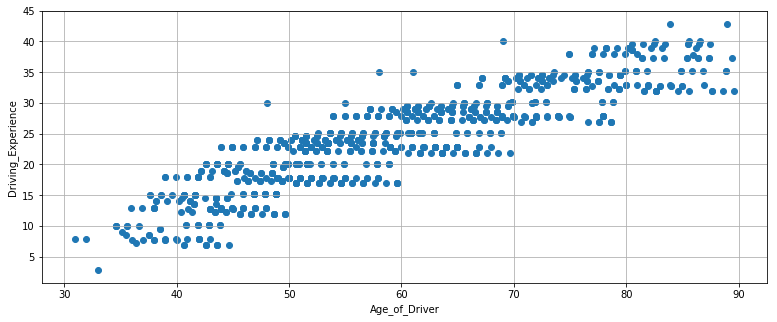

In [35]:
def pair_plot(x_data, y_data):
    f, (ax2) = plt.subplots(1, 1, figsize=(13, 5))
    
    ax2.scatter(x_data, y_data)
    ax2.set_xlabel("Age_of_Driver")
    ax2.set_ylabel("Driving_Experience")
    ax2.grid()

pair_plot(practice_data['Age_of_Driver'].values, practice_data['Driving_Experience'].values)

Можно видеть, что зависимость имеет небольший изгиб и скорее похожа на корень. Попробуем возвести возраст водителя в степень 1.5. 

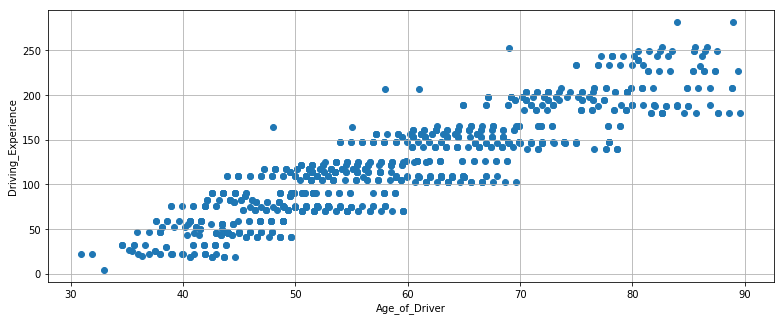

In [36]:
def pair_plot(x_data, y_data):
    f, (ax2) = plt.subplots(1, 1, figsize=(13, 5))
    
    ax2.scatter(x_data, y_data)
    ax2.set_xlabel("Age_of_Driver")
    ax2.set_ylabel("Driving_Experience")
    ax2.grid()

pair_plot(practice_data['Age_of_Driver'].values, practice_data['Driving_Experience'].values ** 1.5)

Отлично! Теперь зависимость очень похожа на линейную, и, более того, имеет не такой уж большой разброс. Построим линейную регрессию, которая бы предсказывала ожидаемый стаж водителя по его возрасту.

In [37]:
import warnings
warnings.filterwarnings("ignore")

import sklearn.linear_model as lm

x_train = practice_data['Age_of_Driver']
x_train = x_train.reshape(len(x_train), 1)
y_train = practice_data['Driving_Experience'] ** 1.5

regression = lm.LinearRegression()
regression.fit(x_train, y_train)
print("regression slope:", regression.coef_)

regression slope: [3.78243975]


Таким образом, получилась линейная регрессия, которая вывела приближенную формулу для стажа водителя относительно его возраста:

$$Experience = 3.78 * \sqrt[3]{Age^{2}} - 30$$

По ней в 30 лет ожидаемый стаж водителя составляет около семи лет. К 60 годам - чуть меньше 29и.